# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4"> Decision Tree Classifier</p>

##  <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;"> Goal: Given various medical indicators, predict the health outcomes of horses </p>

In [450]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Train test Split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Feature Selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif,SelectFromModel
#from autofeatselect import FeatureSelector

# Model Building
from sklearn.tree import DecisionTreeClassifier

#Tree Visualization
from sklearn import tree
import graphviz

# Cross validation
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay,classification_report, roc_curve, roc_auc_score

# Statistical Analysis
from scipy.stats import chi2_contingency
from scipy.stats import randint

import pprint
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [451]:
# Define the style
rc = {
    "axes.facecolor": "#dcf5f7",
    "figure.facecolor": "#dcf5f7",
    "axes.edgecolor": "#000000",
    "grid.color": "#094863",
    "font.family": "arial",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}
sns.set(rc=rc)

In [452]:
class DTModel:

    def __init__(self):
        pass

    def categories_validation(self, train, test):
        print("The categories mismatch in training and test dataset")
        categorical_features_test = test.select_dtypes(include=['object']).columns.to_list()

        equal_mismatch = []

        for feature in categorical_features_test:
            train_unique = set(train[feature].unique()) 
            test_unique = set(test[feature].unique())
            
            if train_unique != test_unique:
                equal_mismatch.append(feature)
                
        return equal_mismatch
    
    
    def encding_numeric_categoric(self, dataframe):
        # Select numerical and categorical features
        numerical_features = dataframe.select_dtypes(include=[np.number])    
        categorical_features = dataframe.select_dtypes(include=['object', 'category'])
        
        # Fill missing values in numerical features with the median
        for col in numerical_features:
            dataframe[col].fillna(dataframe[col].median(), inplace=True)
        
        # Encode categorical features as numerical using factorization
        for col in categorical_features:
            dataframe[col], _ = dataframe[col].factorize()

    
    # Define a function to compute Mutual Information (MI) scores
    def make_mi_score(self, X, y):
        
        # Compute MI scores for feature selection
        mi_score = mutual_info_classif(X, y, discrete_features='auto')
        
        # Create a Series to store MI scores with feature names
        mi_features = pd.Series(mi_score, name="MI Score", index=X.columns).sort_values(ascending=False)
        
        return mi_features

    
    def plot_mi_score(self, score):
        # Define a colorful color palette for the bars
        colors = sns.color_palette('YlGnBu', n_colors=len(score))
        
        plt.figure(figsize=(13, 7))
        sns.barplot(x=score.values, y=score.index, orient='h', palette=colors)
        plt.title('Mutual Information Scores', color='black', fontweight='bold')
        plt.ylabel('Features', color='black', fontweight='bold')
        plt.xticks(rotation=40, color='red')

        # Add the value labels to the bars
        for index, value in enumerate(score.values):
            plt.text(value, index, f'{value:.2f}', color='black', ha='left', va='center')

        plt.tight_layout()  
        return plt.show()



# Initialize the class
objModel = DTModel()


## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;"> Read Data </p>

In [453]:
# Read the data from the source
train = pd.read_csv("../Horse_Health_Data/HorseHealth_train.csv")
test = pd.read_csv("../Horse_Health_Data/HorseHealth_test.csv")

In [454]:
# Create copies of the train and test DataFrames
df_train = train.copy()
df_test = test.copy()

In [455]:
print("Train Shape: ", df_train.shape)
print("Test Shape: ", df_test.shape)

Train Shape:  (1235, 29)
Test Shape:  (824, 28)


## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;"> Basic Data Exploration </p>

In [456]:
df_train.head(10)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
5,5,no,adult,529642,38.1,56.0,32.0,normal,normal,bright_pink,less_3_sec,depressed,hypomotile,none,none,more_1_liter,5.0,decreased,firm,49.0,8.0,cloudy,2.8,no,0,0,0,yes,lived
6,6,yes,adult,534787,38.3,36.0,16.0,cool,reduced,normal_pink,less_3_sec,severe_pain,normal,slight,none,more_1_liter,2.0,decreased,NaN,43.0,75.0,cloudy,1.0,no,3111,0,0,yes,euthanized
7,7,no,adult,529461,39.2,114.0,24.0,cool,reduced,pale_cyanotic,more_3_sec,mild_pain,hypomotile,moderate,slight,none,4.5,absent,distend_small,57.0,7.6,serosanguious,4.5,yes,2207,0,0,yes,died
8,8,no,adult,528742,37.4,48.0,12.0,cool,reduced,normal_pink,less_3_sec,alert,hypermotile,slight,slight,more_1_liter,7.0,normal,firm,40.0,7.8,cloudy,2.6,no,0,0,0,yes,lived
9,9,yes,adult,529640,38.3,129.0,48.0,cool,reduced,pale_pink,less_3_sec,depressed,absent,moderate,slight,none,4.4,NaN,NaN,57.0,4.9,cloudy,2.9,yes,3209,0,0,yes,died


In [457]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [458]:
df_train.describe(exclude="object")

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [459]:
df_train.describe(include="object")

,surgery,age,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data,outcome
count,1235,1235,1196,1175,1214,1229,1191,1215,1212,1155,1214,1045,1022,1187,1235,1235,1235
unique,2,2,4,4,6,3,6,5,4,3,4,5,5,3,2,2,3
top,yes,adult,cool,reduced,pale_pink,less_3_sec,depressed,hypomotile,moderate,slight,more_1_liter,absent,distend_small,serosanguious,yes,yes,lived
freq,887,1160,700,724,284,834,429,664,543,758,604,493,482,570,929,668,574


<p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;"> Data Checks to perform </p>

- Check Missing values
- Check Duplicates
- Check data type
- Check the number of unique values of each column
- Check statistics of data set
- Check various categories present in the different categorical column

#### Check Missing values

In [460]:
# Null values
Column_with_na = df_train.isnull().sum()
Column_with_na[Column_with_na > 0]

temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
rectal_exam_feces        190
abdomen                  213
abdomo_appearance         48
dtype: int64

In [461]:
## Here we will check the percentage of nan values present in each feature
feature_na = [feature for feature in df_train.columns if df_train[feature].isnull().sum() > 0 ]

for feature in feature_na:
    print(feature, np.round(df_train[feature].isnull().mean() * 100,4), " % missing")

temp_of_extremities 3.1579  % missing
peripheral_pulse 4.8583  % missing
mucous_membrane 1.7004  % missing
capillary_refill_time 0.4858  % missing
pain 3.5628  % missing
peristalsis 1.6194  % missing
abdominal_distention 1.8623  % missing
nasogastric_tube 6.4777  % missing
nasogastric_reflux 1.7004  % missing
rectal_exam_feces 15.3846  % missing
abdomen 17.247  % missing
abdomo_appearance 3.8866  % missing


In [462]:
# Null valuse percentage greater than 10%
columns_with_null_values_total = (df_train.isnull().sum() / len(df_train)) * 100
columns_with_null_values_percentage = columns_with_null_values_total[columns_with_null_values_total > 10].sort_values(ascending=False)

columns_with_null_values_percentage

abdomen              17.246964
rectal_exam_feces    15.384615
dtype: float64

<b>observation:</b> There are many missing values. The features abdomen, and rectal_exam_feces are missing more than 10%

Let's plot some diagram for this relationship

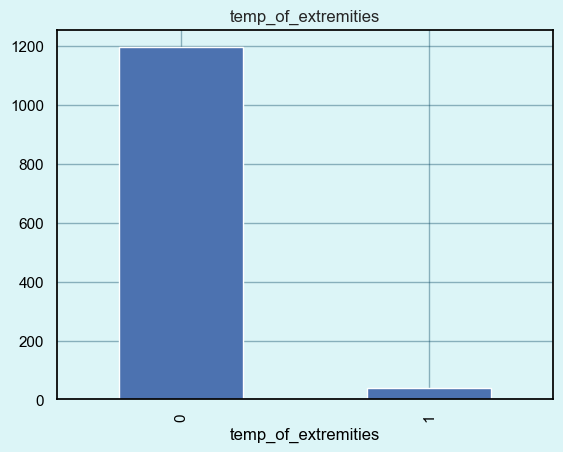

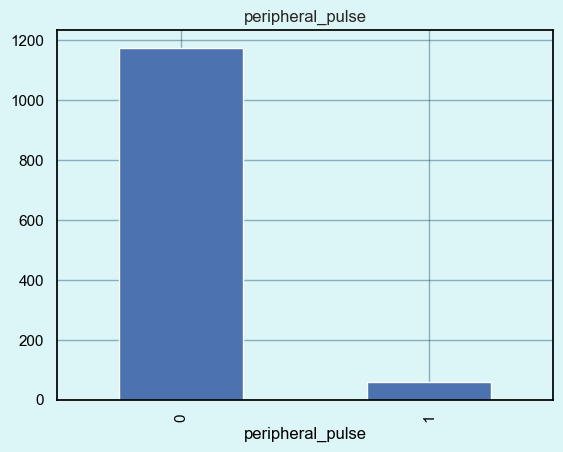

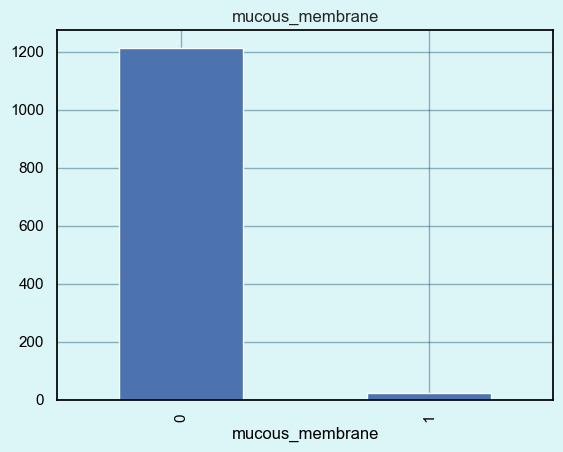

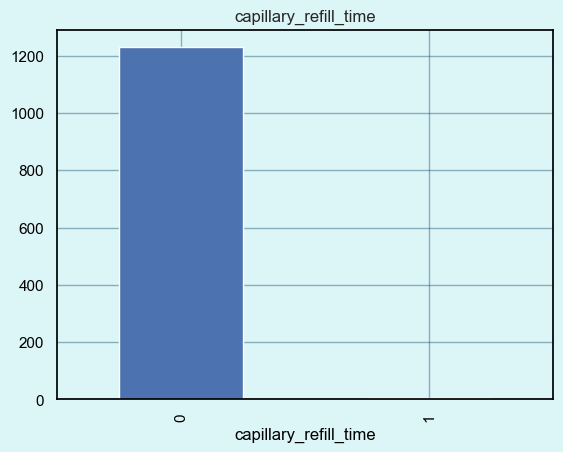

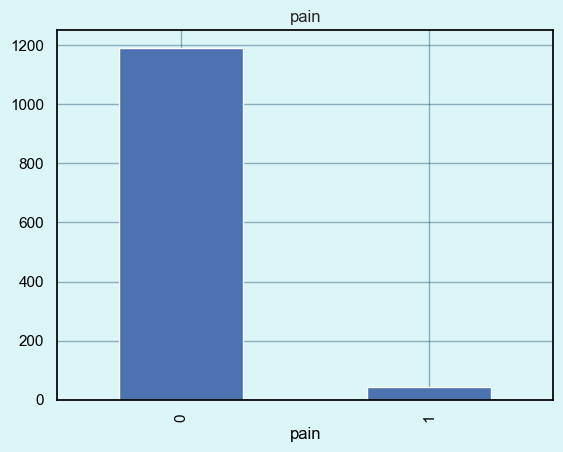

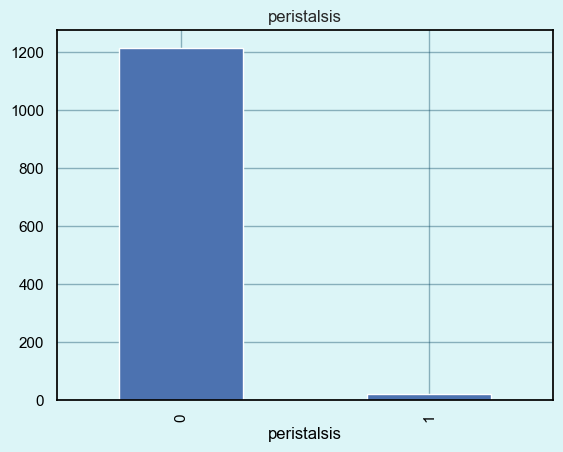

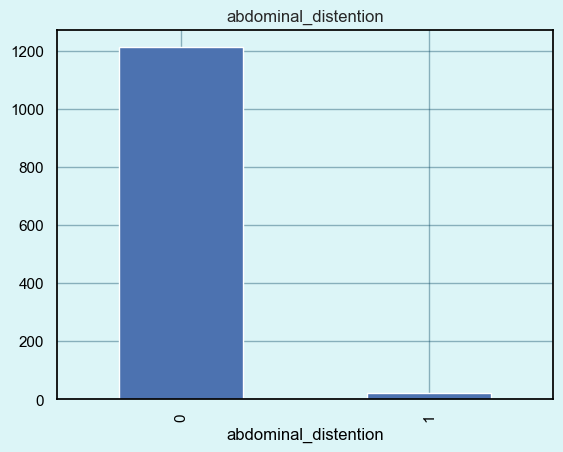

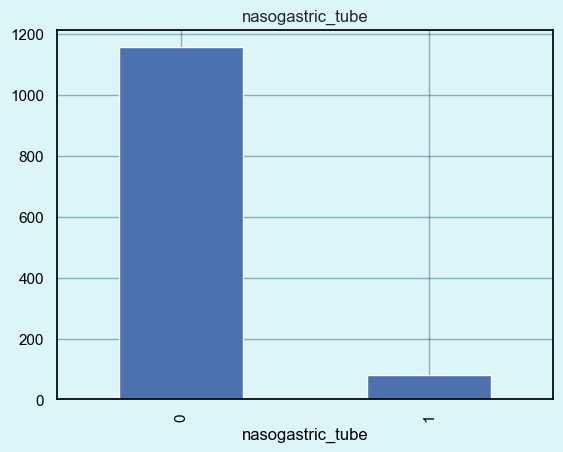

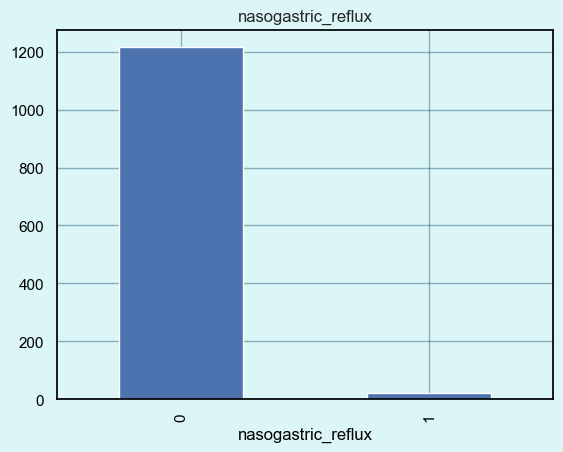

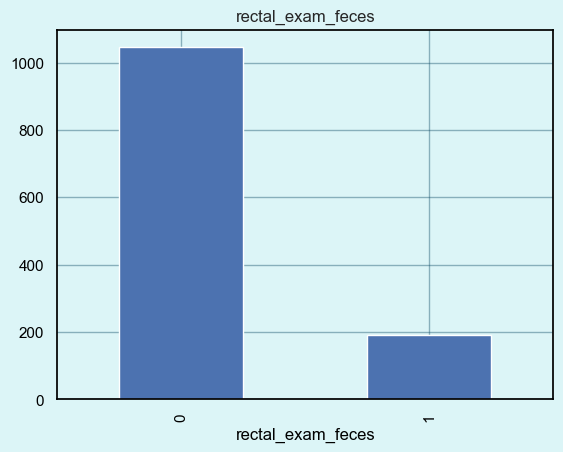

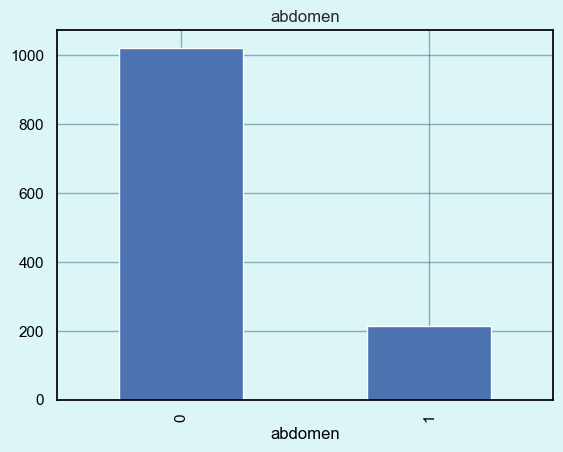

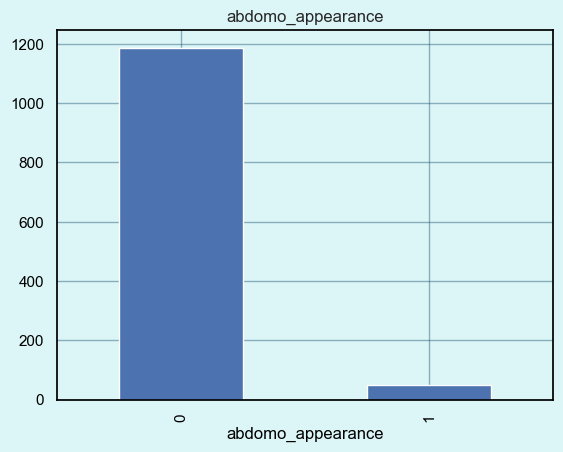

In [463]:
for feature in feature_na:
    data = df_train.copy()
    
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    
    # let's calculate the mean Stroke where the information is missing or present
    data.groupby(feature)["outcome"].count().plot.bar()
    plt.title(feature)
    plt.show()

Here With the relation between the missing values and the dependent variable is clearly visible.So We need to replace these nan values with something meaningful

#### Check Duplicates

In [464]:
df_train.duplicated().sum()

0

In [465]:
df_test.duplicated().sum()

0

#### Check the number of unique values of each column

To better organize our data, let's divide our features into two types: 
1) categorical 

2) numerical.

In [466]:
feature_cat = df_train.select_dtypes(include = ["object"]).columns.to_list()
print("Categorical Features:", feature_cat)

feature_num = df_train.select_dtypes(exclude = ["object"]).columns.to_list()
print("Numerical Features:",feature_num)

Categorical Features: ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'outcome']
Numerical Features: ['id', 'hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


In [467]:
print("Train Dataset Categorical Feature Uniqueness:")
print("*" * 60)
for feature in feature_cat:
    print('{}: Unique Count: {}\n {}\n'.format(feature, len(df_train[feature].unique()), df_train[feature].unique()))

Train Dataset Categorical Feature Uniqueness:
************************************************************
surgery: Unique Count: 2
 ['yes' 'no']

age: Unique Count: 2
 ['adult' 'young']

temp_of_extremities: Unique Count: 5
 ['cool' 'cold' 'normal' 'warm' nan]

peripheral_pulse: Unique Count: 5
 ['reduced' 'normal' nan 'absent' 'increased']

mucous_membrane: Unique Count: 7
 ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]

capillary_refill_time: Unique Count: 4
 ['more_3_sec' 'less_3_sec' nan '3']

pain: Unique Count: 7
 ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan 'slight']

peristalsis: Unique Count: 6
 ['absent' 'hypomotile' 'normal' 'hypermotile' nan 'distend_small']

abdominal_distention: Unique Count: 5
 ['slight' 'moderate' 'none' 'severe' nan]

nasogastric_tube: Unique Count: 4
 ['slight' 'none' 'significant' nan]

nasogastric_reflux: Unique Count: 5
 ['less_1_liter' 'more_1_liter' 'none' nan 'slight']

rectal_ex

In [468]:
print("Train Dataset Numerical Feature Uniqueness:")
print("*" * 60)
for feature in feature_num:
    if len(df_train[feature].unique()) <= 5:
        print('{}: Unique Count: {}\n {}\n'.format(feature, len(df_train[feature].unique()), df_train[feature].unique()))
    else:
        print('{}: Unique Count: {}\n'.format(feature, len(df_train[feature].unique())))

Train Dataset Numerical Feature Uniqueness:
************************************************************
id: Unique Count: 1235

hospital_number: Unique Count: 255

rectal_temp: Unique Count: 43

pulse: Unique Count: 50

respiratory_rate: Unique Count: 37

nasogastric_reflux_ph: Unique Count: 26

packed_cell_volume: Unique Count: 49

total_protein: Unique Count: 83

abdomo_protein: Unique Count: 54

lesion_1: Unique Count: 57

lesion_2: Unique Count: 4
 [   0 1400 3111 3112]

lesion_3: Unique Count: 2
 [   0 2209]



In [469]:
mis_match = objModel.categories_validation(df_train, df_test)
mis_match

The categories mismatch in training and test dataset


['pain', 'peristalsis', 'nasogastric_reflux', 'rectal_exam_feces']

<b>Observation:</b> Some columns contain inconsistent values that need to be addressed

## <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;"> Exploratory Data Analysis </p>

In [470]:
numerical_features = train.select_dtypes(include=[np.number])    
categorical_features = train.select_dtypes(include=['object', 'category'])

### Heat Map

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Correation Heatmap:</b> The correlation heatmap is a valuable tool for gaining insights into your dataset, helping you identify relationships between variables, and potentially informing feature selection or further analysis.
    <ul>
        <li>A values close to 1 indicates a strong positive linear correlation, meaning that as one variable increases, the other also increases linearly.</li>
        <li>A values close -1 indicates a perfect negative correlation, meaning that as one variable increases, the other decreases linearly.</li>
        <li>A value of 0 indicates no linear correlation between the variables.</li>
    </ul>
</div>


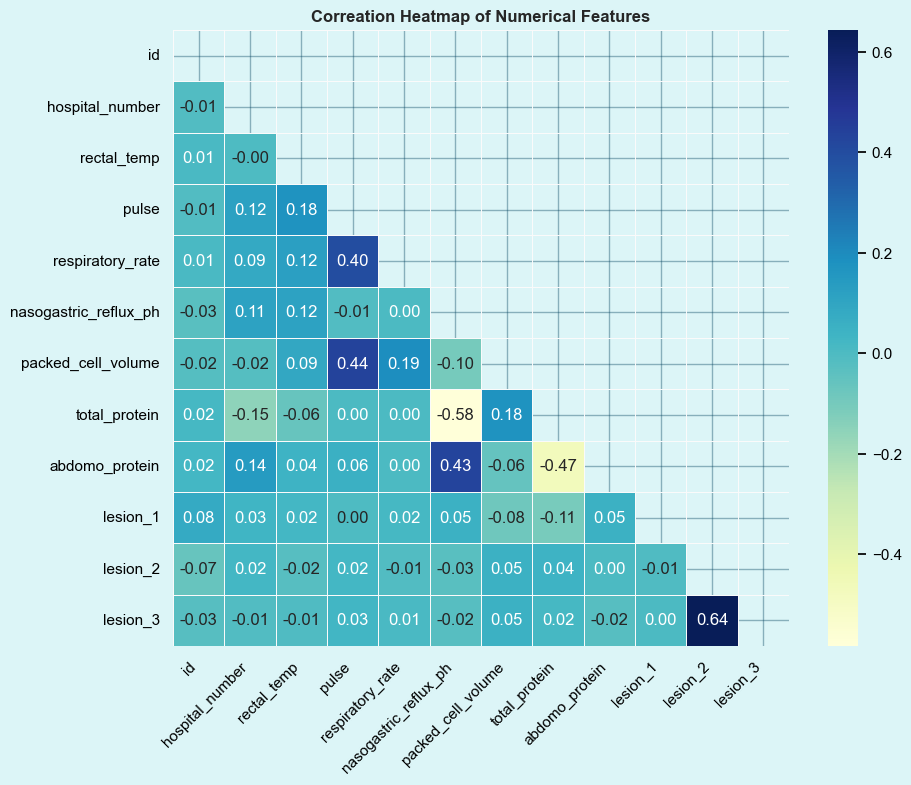

In [471]:
# Compute the correation matrix for numerical features
corr_matrix = df_train[numerical_features.columns].corr()
mask = np.triu(corr_matrix)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', mask=mask, linewidth=0.5, square=True, linecolor='#fafafa', fmt=".2f")

# Set plot title
plt.title('Correation Heatmap of Numerical Features', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.show()

### Chi-Squared Test

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Chi-Squared Test:</b> The chi-squared test is a statistical hypothesis test used to determine if there is a significant association between two categorical variables. It is often used to assess whether there is a relationship between a categorical independent variables and the categorical dependent variable. The test is based on the differences between the expected and observed frequencies in a contingency table.
    <ul>
        <li><code>Null Hypothesis (H0)</code>: There is no significant association between the two categorical variables; they are independent.</li>
        <li><code>Alternative Hypothesis (H1)</code>: There is a significant association between the two categorical variables; they are dependent.</li>
        <li><code>crosstab</code>: Construct a contingency table that summarizes the observed counts of the data and Calculate the expected frequencies for each cell in the contingency table under the assumption that the variables are independent</li>
        <li><code>chi-squared</code>: Calculate the difference between the observed and expected frequencies.</li>
        <li><code>p-value</code>: Calculate the p-value associated with the test statistic. The p-value represents the probability of observing a test statistic
        <br><br>
        <li>Compare the p-value to a predetermined significance level (e.g., 0.05). If the p-value is less than the significance level, reject the null hypothesis that means there is significant association between the two categorical variables. If there is no significant association between the two categorical variables null hypothesis is accepted. So based on this we can exclude the features that have values <b>higher than the predetermined significance level.</b></li>
</div>

In [472]:
#  Select categorical features with a moderate number of unique values
value_counts = df_train.nunique()
categorical_values = value_counts[(value_counts > 1) & (value_counts < 20)].index.tolist()
categorical_features_chi = list(set(categorical_values) - set(['outcome']))

#categorical_features_chi

In [473]:
threshold = 0.05

print(f'{"Columns":<26} | {f"Test score":<26}| Test result')
print("-" * 69)

for feature in categorical_features_chi:
    
    # Create a contingency table
    contingency_table = pd.crosstab(df_train["outcome"], df_train[feature])
    
    # Perform the chi-squared test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    if p < threshold:
        print(f"\033[32m{feature:<28}{p:<28}Passed")
    else:
        print(f"\033[31m{feature:<28}{p:<28}Failed")

Columns                    | Test score                | Test result
---------------------------------------------------------------------
capillary_refill_time       2.5603653965366966e-23      Passed
abdomen                     2.0143756236778237e-14      Passed
lesion_2                    0.0032827291154187807       Passed
peristalsis                 2.2818709464826807e-23      Passed
lesion_3                    0.4633755810904284          Failed
surgical_lesion             2.5746694456784413e-20      Passed
abdomo_appearance           8.943335752359429e-34       Passed
nasogastric_reflux          3.9393105252613376e-07      Passed
cp_data                     4.4431463457300535e-18      Passed
surgery                     1.337203791699957e-07       Passed
age                         9.515417931070396e-13       Passed
peripheral_pulse            2.0774862310928085e-30      Passed
abdominal_distention        4.010442692851039e-26       Passed
nasogastric_tube            2.632804392350

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;">Numerical Features Data Exploration</p>

#### Numerical Features Distribution

In [474]:
# Exclude 'id' and 'hospital_number'
numerical_features_distribution = list(set(numerical_features.columns) - set(['id', 'hospital_number', 'lesion_3'])) 

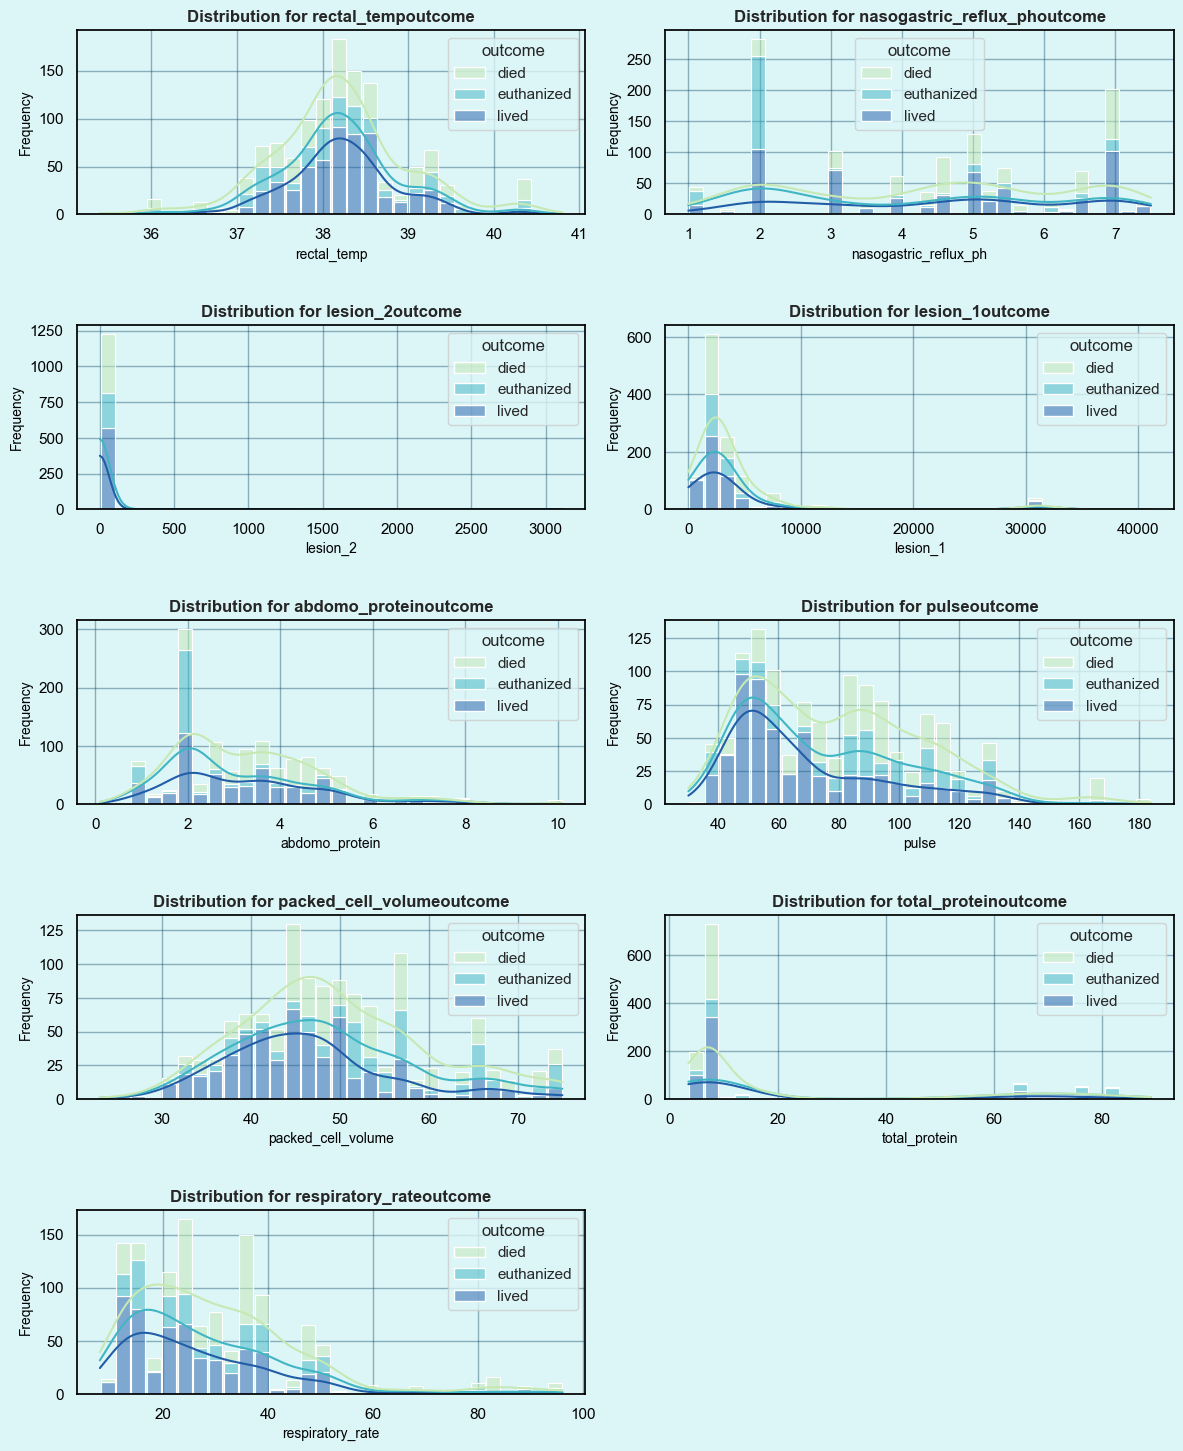

In [475]:
 # Number of columns in each row
num_cols = 2 

# Calculate the number of rows needed
num_rows = (len(categorical_features.columns) + 1) // num_cols  

# Create a figure with a specific size for subplots
plt.figure(figsize=(12, 26)) 

for i, feature in enumerate(numerical_features_distribution, start=1):
    plt.subplot(num_rows, num_cols, i) 
    sns.histplot(data=df_train, x=feature, hue='outcome', palette="YlGnBu", multiple="stack", kde=True, bins=30, shrink=0.9)
    plt.title(f'Distribution for {feature}outcome', fontsize=12, fontweight='bold')
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

# Ensure proper spacing between subplots
plt.tight_layout(h_pad=2.6)  
plt.show()


### Distplots for Numerical Variables
To explore the distribution of our numerical features, we'll use distplots instead of countplots, which are better suited for categorical data.

Countplot is used to visualize the frequency of categorical data, while distplot is used to visualize the distribution of continuous data.

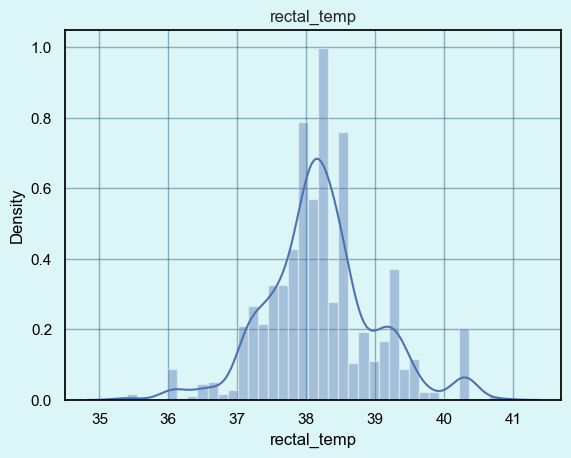

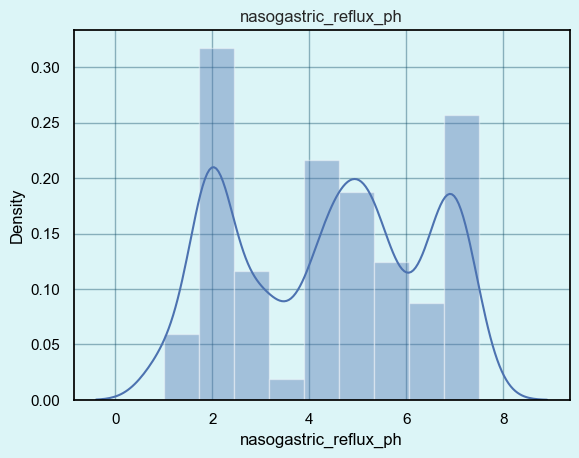

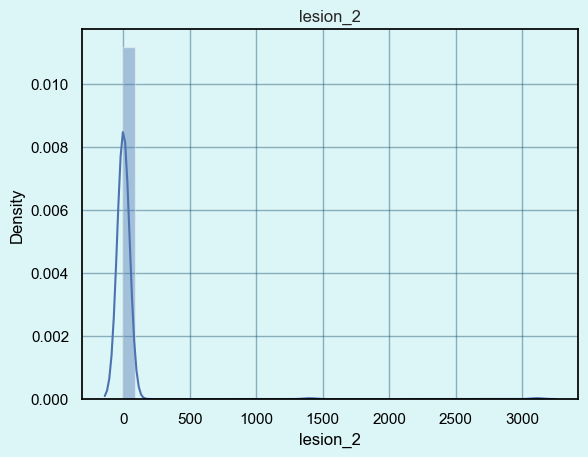

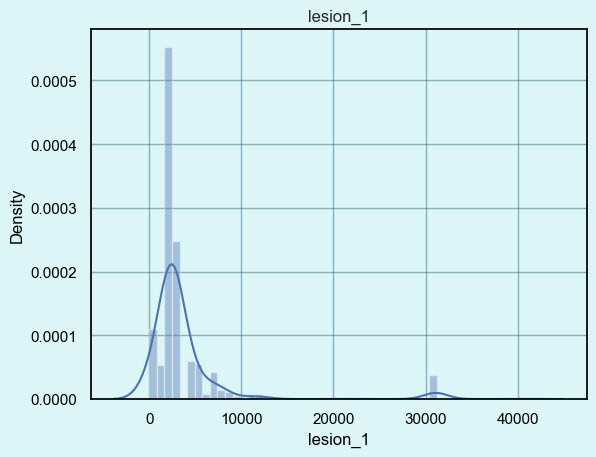

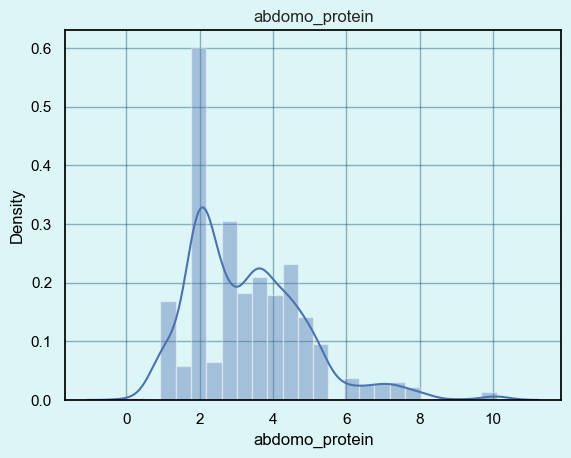

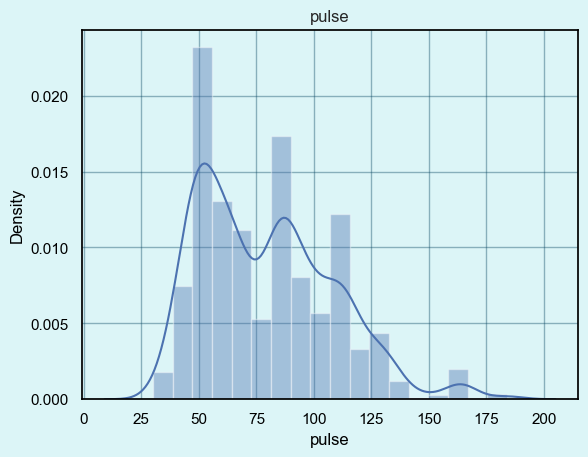

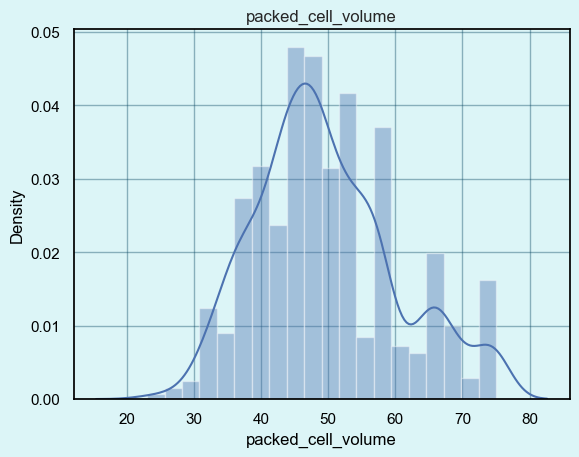

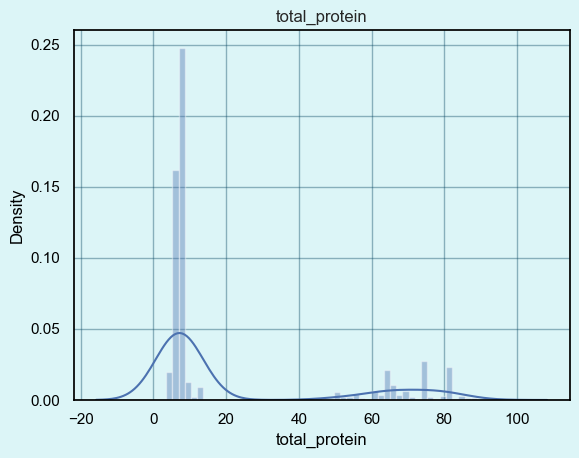

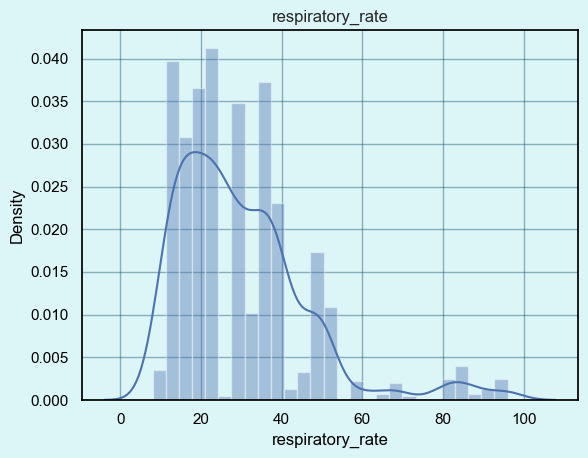

In [476]:
for feature in numerical_features_distribution:
    sns.distplot(df_train[feature])
    plt.title(feature)
    plt.show()

#### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%">Numerical Features Outliers</p>

Box plot: this will allow us to easily identify the distribution of our observations and detect any outliers.

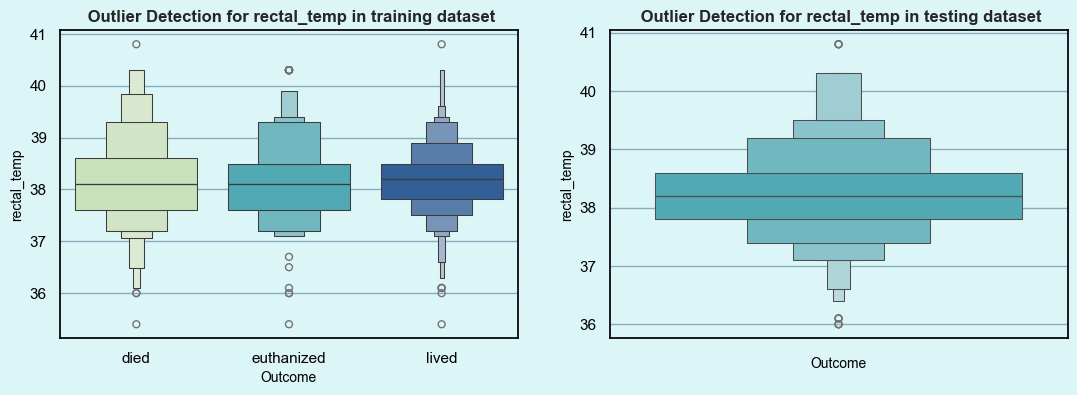

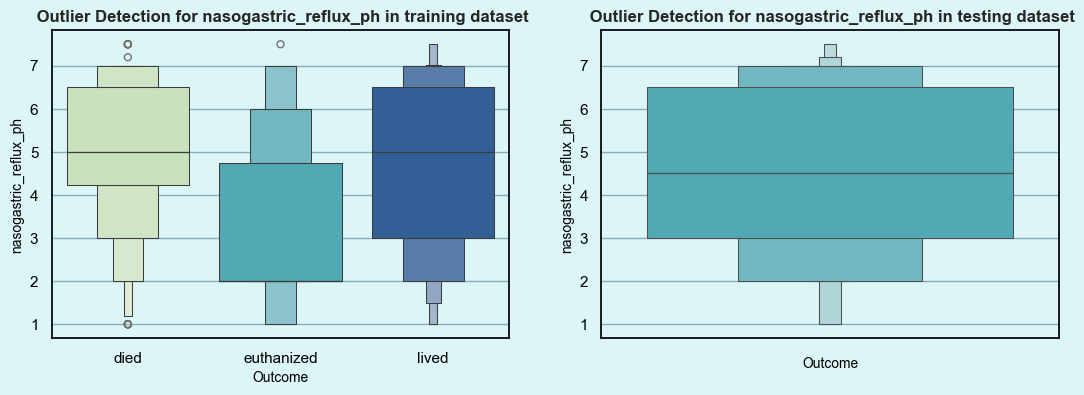

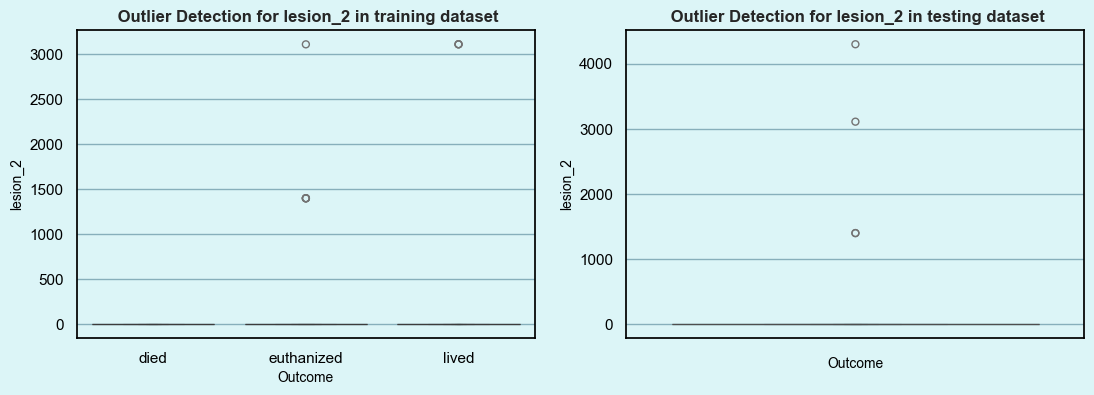

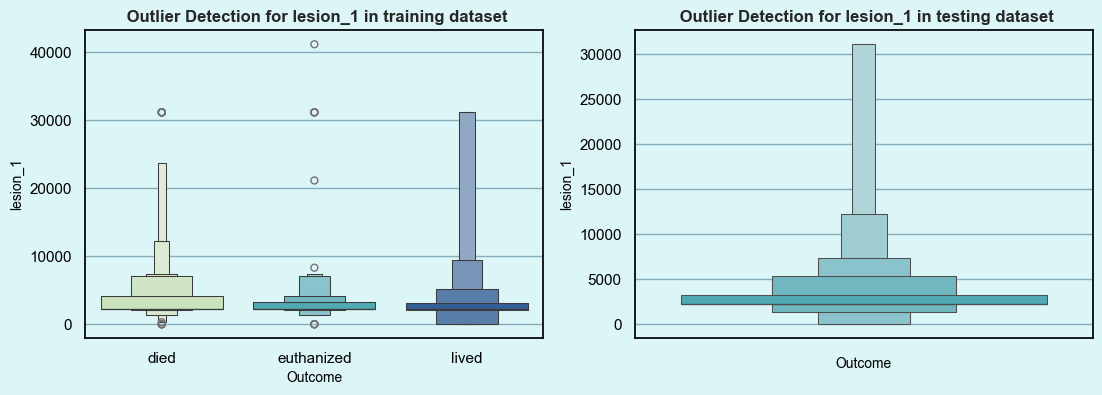

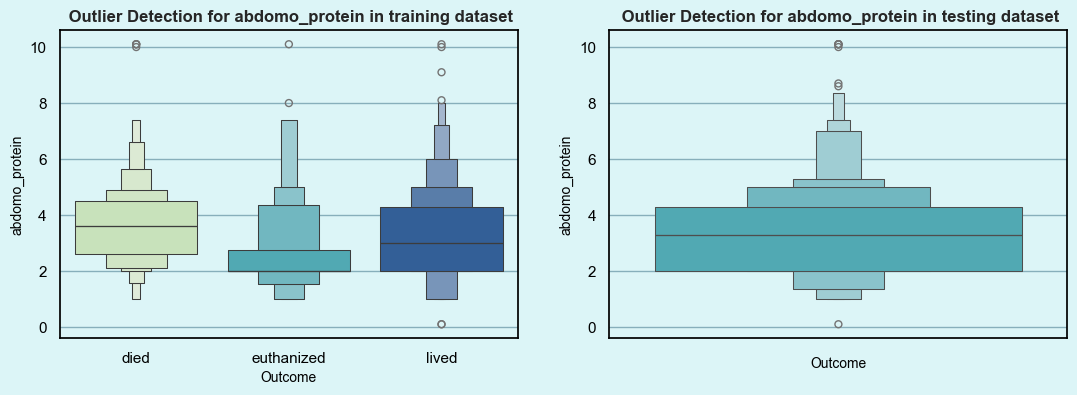

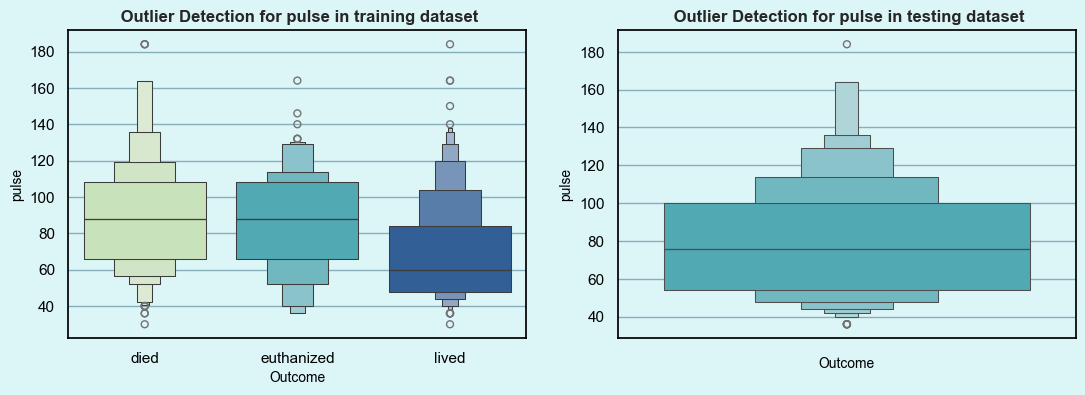

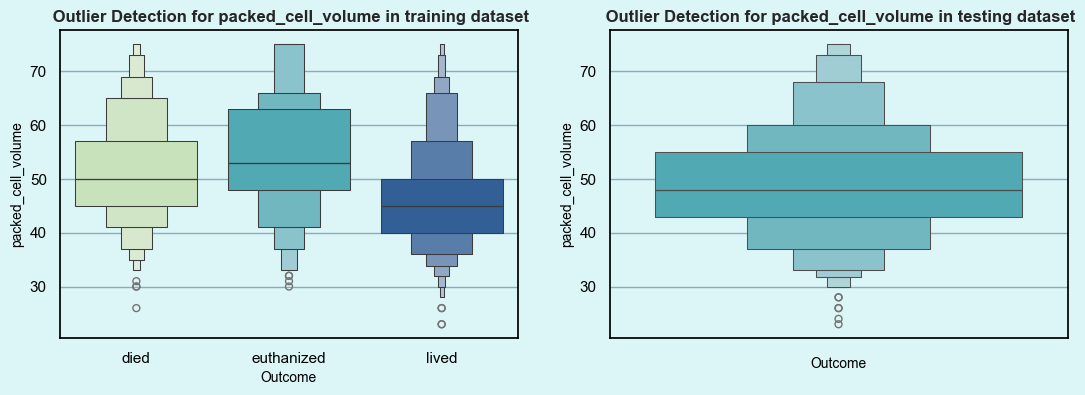

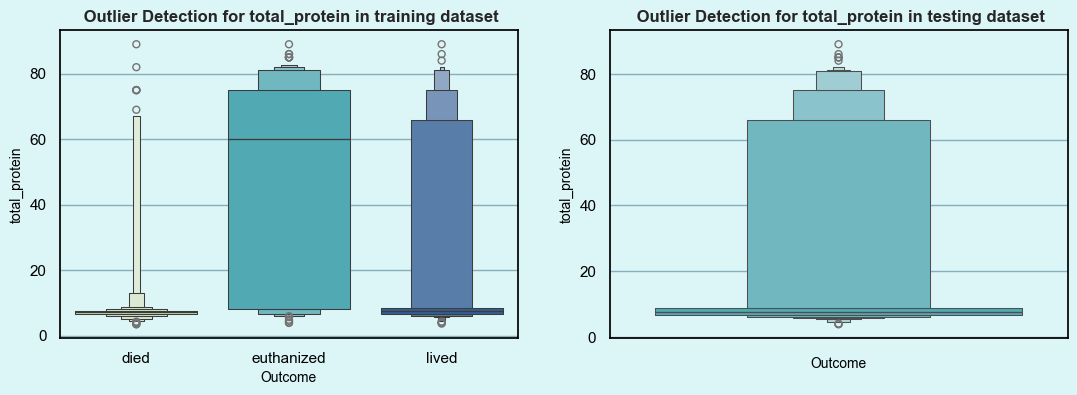

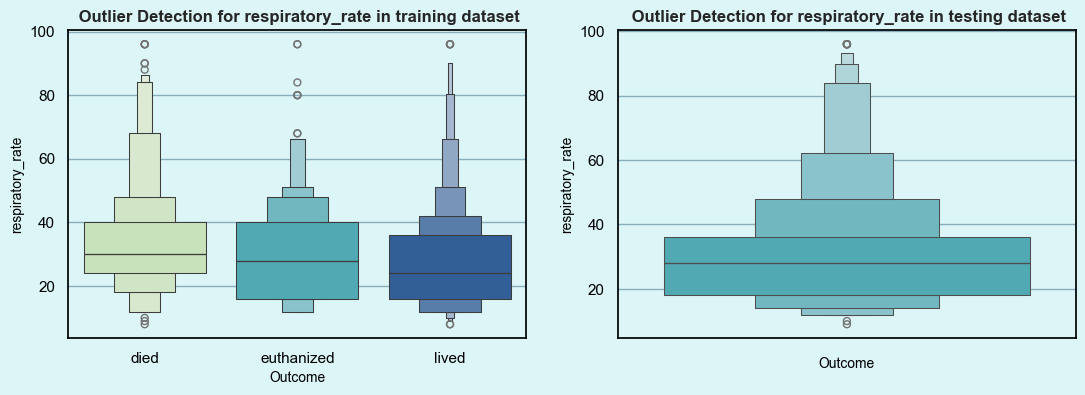

In [477]:
# Numerical features
for feature in numerical_features_distribution:

    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    sns.boxenplot(data=df_train, x='outcome', y=feature, palette="YlGnBu")
    plt.title(f' Outlier Detection for {feature} in training dataset', fontsize=12, fontweight='bold')
    plt.xlabel('Outcome', fontsize=10)
    plt.ylabel(feature, fontsize=10)

    plt.subplot(1,2,2)
    sns.boxenplot(data=df_test, y=feature, palette="YlGnBu")
    plt.title(f' Outlier Detection for {feature} in testing dataset', fontsize=12, fontweight='bold')
    plt.xlabel('Outcome', fontsize=10)
    plt.ylabel(feature, fontsize=10)

    plt.show()

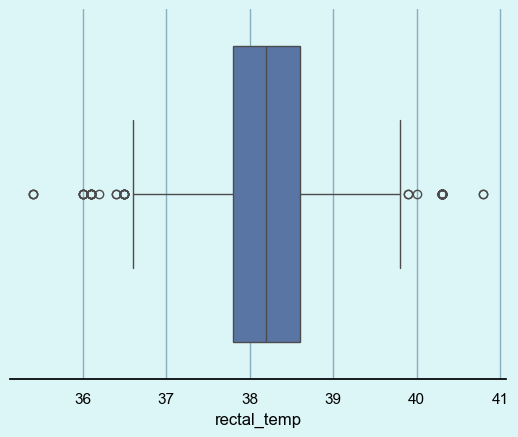

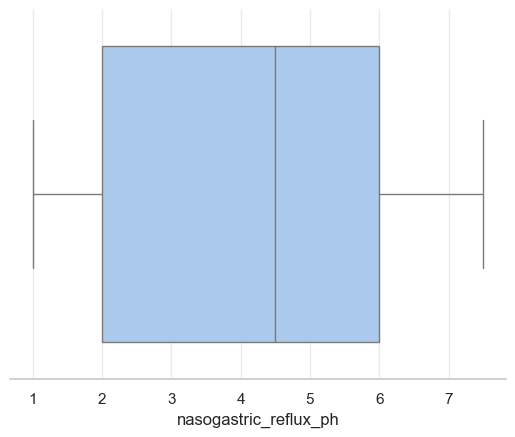

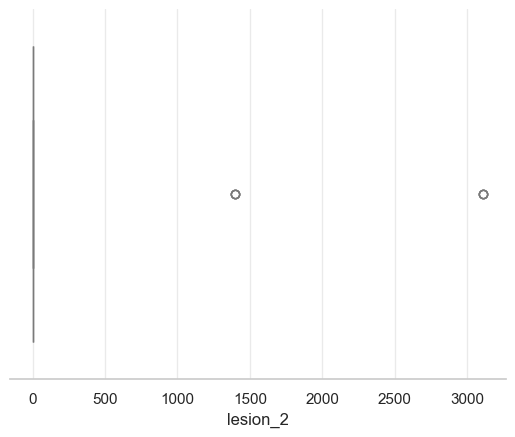

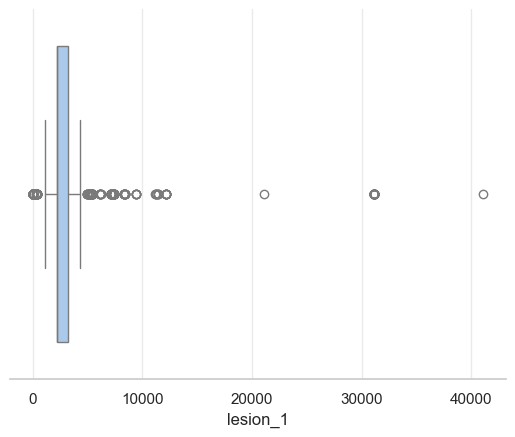

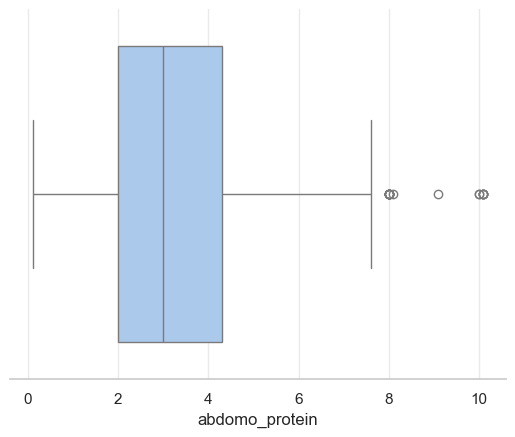

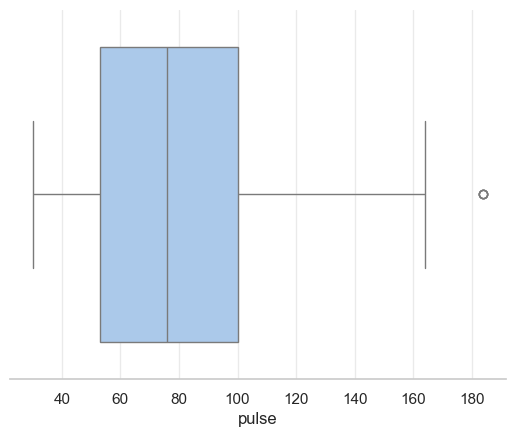

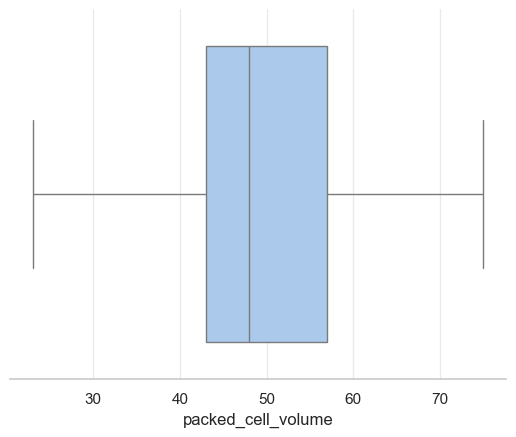

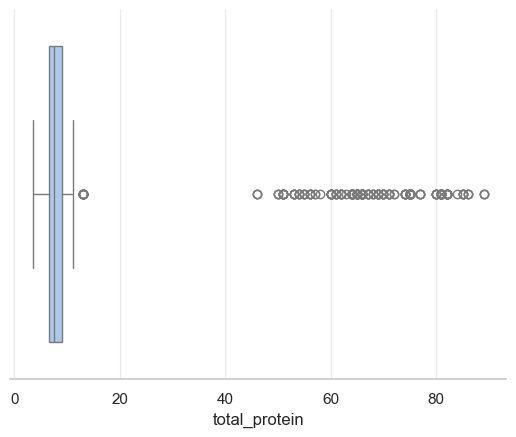

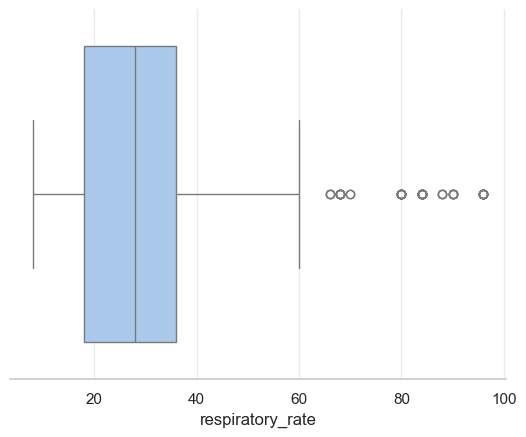

In [478]:
for feature in numerical_features_distribution:
    
    sns.boxplot(x=feature, data=df_train)
    sns.set_style('whitegrid')
    sns.set_palette('pastel')
    sns.despine(left=True)

    plt.show()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;">Categorical Features Data Exploration</p>

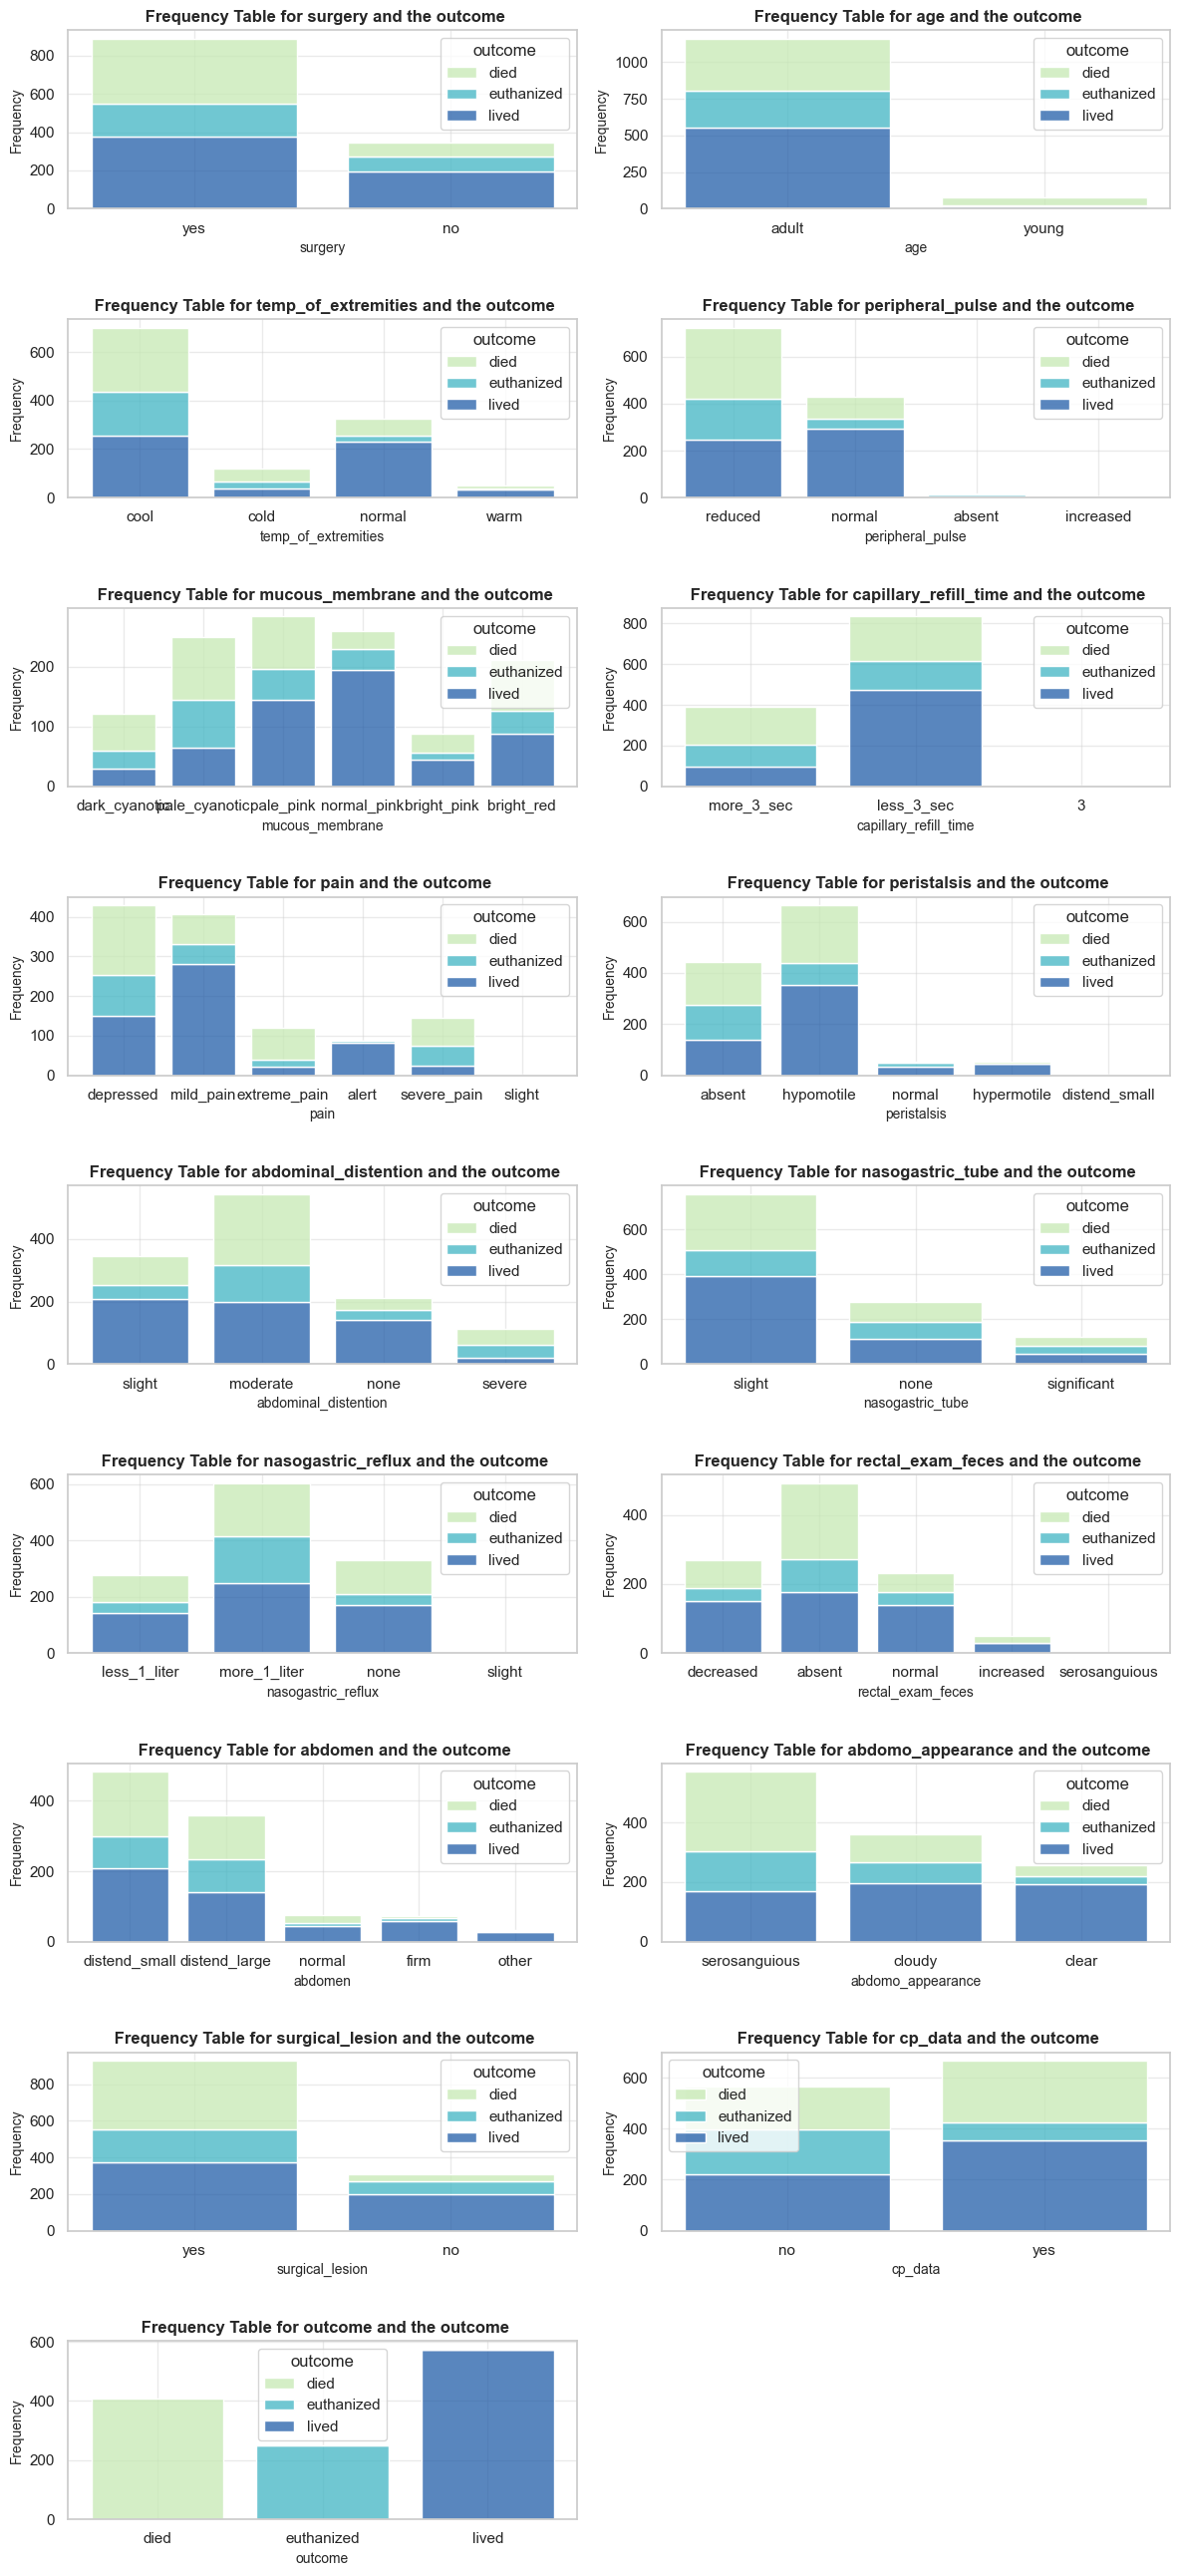

In [479]:
num_cols = 2  # Number of columns in each row
num_rows = (len(categorical_features.columns) + 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(12, 26))

for i, feature in enumerate(categorical_features.columns, start=1):
    plt.subplot(num_rows, num_cols, i) 
    sns.histplot(data=df_train, x=feature, hue='outcome', palette="YlGnBu", multiple="stack", shrink=0.8)
    plt.title(f' Frequency Table for {feature} and the outcome', fontsize=12, fontweight='bold')
    plt.xlabel(feature, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

plt.tight_layout(h_pad=2.6)  # Ensure proper spacing between subplots
plt.show()


##### Plot for Traget variable

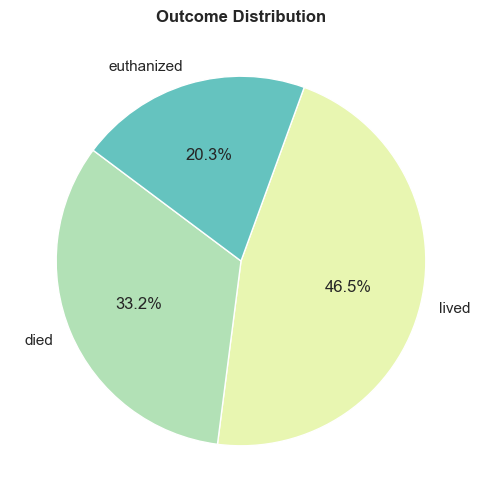

In [480]:
features_name = df_train['outcome'].value_counts().index
features_values = df_train['outcome'].value_counts().values

colors = sns.color_palette('YlGnBu')

plt.figure(figsize=(8, 6)) 
plt.pie(features_values, labels=features_name, colors=colors, autopct='%1.1f%%', startangle=70, counterclock=False)

plt.title('Outcome Distribution', fontweight='bold')

plt.show()

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> Mutual Information (MI) Score:</b> Mutual Information (MI) is a measure of the dependence between two random variables. It quantifies how much knowing one variable can tell you about another variable. A higher MI score indicates a stronger relationship or dependency between the feature and the target variable.
</div>

In [481]:
df_train_out = df_train.copy()
df_train_out.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [482]:
# Apply encoding function to prepare the data
#objModel.encding_numeric_categoric(df_train_out)
#df_train_out.head()

In [483]:
mi_df = df_train_out.copy()
# Extract the target variable 'outcome' and store it in 'mi_y'
mi_y = mi_df.pop("outcome")

# Apply encoding function to prepare the data
objModel.encding_numeric_categoric(mi_df)

# Compute MI scores for the features in mi_df with respect to mi_y
mi_score = objModel.make_mi_score(mi_df, mi_y)
print(f"\033[34m{mi_score}")

hospital_number          0.193622
lesion_1                 0.168648
abdomo_protein           0.152673
pain                     0.141332
total_protein            0.140789
pulse                    0.140394
packed_cell_volume       0.133931
nasogastric_reflux_ph    0.118976
respiratory_rate         0.086743
mucous_membrane          0.080212
peripheral_pulse         0.065421
abdomo_appearance        0.059936
abdominal_distention     0.057310
surgical_lesion          0.049270
nasogastric_reflux       0.046359
temp_of_extremities      0.045007
abdomen                  0.043830
id                       0.039763
surgery                  0.038891
cp_data                  0.035701
rectal_exam_feces        0.035660
peristalsis              0.033163
rectal_temp              0.023247
age                      0.017317
nasogastric_tube         0.013992
capillary_refill_time    0.013426
lesion_2                 0.006313
lesion_3                 0.000527
Name: MI Score, dtype: float64


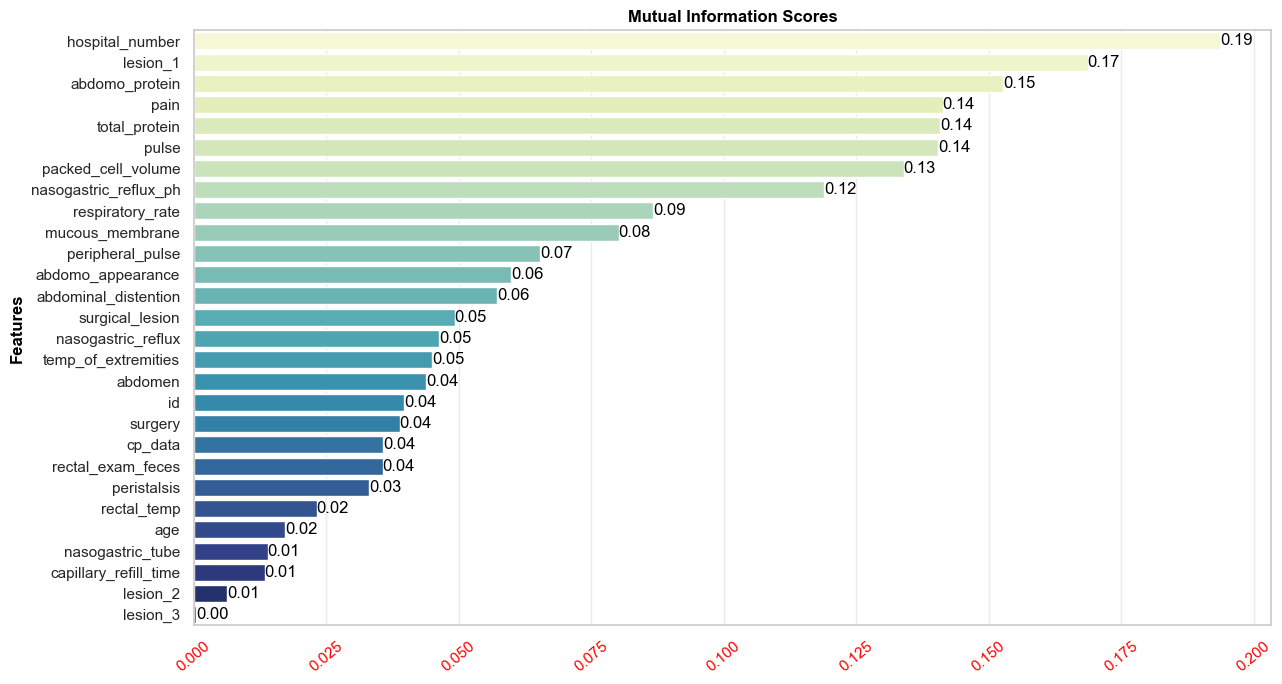

In [484]:
objModel.plot_mi_score(mi_score)

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px;">Feature Engineering</p>

In [485]:
df_train_full = df_train_out.copy()
df_test_full = df_test.copy()

In [486]:
# columns to be dropped
columns_to_drop = ['id', 'lesion_3']

In [487]:
df_train_full.drop(columns=columns_to_drop, axis=1, inplace=True)
df_test_full.drop(columns=columns_to_drop, axis=1, inplace=True)

#### Handling Missing Data

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">    
        <ul>
        <li>Select numeric columns</li>
        <li>Select categorical columns</li>
        <li>Fill NAN values in the numerical columns with <b>median</b></li>
        <li>Fill NAN values in the categirical columns with <b>factoriztion</b></li>
        <br>
        <li><b>Factorization :</b> Factorization assigns a unique numerical code to each distinct category or label in a categorical column.</li>
    </ul>
</div>

In [488]:
numerical_features = df_train_full.select_dtypes(include=[np.number]).columns   
categorical_features = df_train_full.select_dtypes(include=['object']).columns

In [489]:
# Apply encoding function to prepare the data
objModel.encding_numeric_categoric(mi_df)

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>🖊️ Note :</b> Address the previously findout inconsistency columns.
        <ul>
        <li>In the testing dataset, "slight" is referred to as "moderate", so we replace all values in the training dataset pain column from "slight" to "moderate" and so to the other inconsistency columns based on there values.</li>
    </ul>
</div>

In [490]:
df_train_full["pain"] = df_train_full["pain"].replace('slight', 'moderate')
df_train_full["peristalsis"] = df_train_full["peristalsis"].replace('distend_small', 'normal')
df_train_full["rectal_exam_feces"] = df_train_full["rectal_exam_feces"].replace('serosanguious', 'absent')
df_train_full["nasogastric_reflux"] = df_train_full["nasogastric_reflux"].replace('slight', 'none')

In [491]:
for feature in categorical_features:
    print(f"{feature:<36} - {df_train_full[feature].unique()}")

surgery                              - ['yes' 'no']
age                                  - ['adult' 'young']
temp_of_extremities                  - ['cool' 'cold' 'normal' 'warm' nan]
peripheral_pulse                     - ['reduced' 'normal' nan 'absent' 'increased']
mucous_membrane                      - ['dark_cyanotic' 'pale_cyanotic' 'pale_pink' 'normal_pink' 'bright_pink'
 'bright_red' nan]
capillary_refill_time                - ['more_3_sec' 'less_3_sec' nan '3']
pain                                 - ['depressed' 'mild_pain' 'extreme_pain' 'alert' 'severe_pain' nan
 'moderate']
peristalsis                          - ['absent' 'hypomotile' 'normal' 'hypermotile' nan]
abdominal_distention                 - ['slight' 'moderate' 'none' 'severe' nan]
nasogastric_tube                     - ['slight' 'none' 'significant' nan]
nasogastric_reflux                   - ['less_1_liter' 'more_1_liter' 'none' nan]
rectal_exam_feces                    - ['decreased' 'absent' nan 'normal' 'incr

<b>Ordinal features:</b> are a type of categorical feature that have a specific order or ranking among them. These features represent characteristics that can be ordered or ranked into distinct categories.

<b>Ordinal mapping:</b> is a technique used in data preprocessing,  which converts categorical or ordinal features with meaningful orderings into numerical values. These numerical values retain the inherent ordinal relationship between categories. By using these mappings, we preserve the ordinal relationships between categories, which can be crucial for certain models to make meaningful predictions.

In [492]:
# Define ordinal mappings
ordinal_mappings = {
    'temp_of_extremities': {'cool': 0, 'cold': 1, 'normal': 2, 'warm': 3},
    'peripheral_pulse': {'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3},
    'capillary_refill_time': {'less_3_sec': 0, '3': 1, 'more_3_sec': 2},
    'pain': {'moderate': 0, 'mild_pain': 1, 'alert': 2, 'depressed': 3, 'severe_pain': 4, 'extreme_pain': 5},
    'abdominal_distention': {'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3},
    'nasogastric_tube': {'none': 0, 'slight': 1, 'significant': 2},
    'nasogastric_reflux': {'none': 0, 'slight': 1, 'less_1_liter': 2, 'more_1_liter': 3}
}

ordinal_mappings

{'temp_of_extremities': {'cool': 0, 'cold': 1, 'normal': 2, 'warm': 3},
 'peripheral_pulse': {'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3},
 'capillary_refill_time': {'less_3_sec': 0, '3': 1, 'more_3_sec': 2},
 'pain': {'moderate': 0,
  'mild_pain': 1,
  'alert': 2,
  'depressed': 3,
  'severe_pain': 4,
  'extreme_pain': 5},
 'abdominal_distention': {'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3},
 'nasogastric_tube': {'none': 0, 'slight': 1, 'significant': 2},
 'nasogastric_reflux': {'none': 0,
  'slight': 1,
  'less_1_liter': 2,
  'more_1_liter': 3}}

In [493]:
ordinal_features = ['temp_of_extremities', 'peripheral_pulse', 'capillary_refill_time', 'pain', 'abdominal_distention', 
                    'nasogastric_tube', 'nasogastric_reflux']

<b>Nominal features</b> are a type of categorical features, but it do not have any inherent order or ranking among them. These features describe characteristics that can be divided into distinct groups or classes.

In [494]:
nominal_features = list(set(categorical_features) - set(ordinal_features))
pprint.pprint(nominal_features, compact=True)
print("\n")
nominal_features.remove("outcome")
pprint.pprint(nominal_features, compact=True)

['age', 'abdomen', 'outcome', 'peristalsis', 'surgical_lesion',
 'abdomo_appearance', 'surgery', 'mucous_membrane', 'cp_data',
 'rectal_exam_feces']


['age', 'abdomen', 'peristalsis', 'surgical_lesion', 'abdomo_appearance',
 'surgery', 'mucous_membrane', 'cp_data', 'rectal_exam_feces']


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; ">Pipelines</p>

<div style="border-radius: 6px; border: #004ed4 solid; padding: 26px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b>📚 Pipelines:</b> Pipelines are a simple way to  encapsulating the entire data preprocessing workflow in to a single object. Pipelines are valuable for organization, reproducibility, and modularity while helping to avoid common pitfalls like data leakage. By encapsulating all the necessary steps in one object, pipelines simplify the process of developing, evaluating, and model deploying process.
    <ul>
    <br>
        <li><b>QuantileTransformer</b> : Applying a quantile transformation facilitates the conversion of numerical features into a normal distribution, potentially enhancing their adherence to Gaussian characteristics and it can be advantageous for certain machine learning algorithms.</li>
        <br>
        <li><b>StandardScaler</b> : Applying a standardizer scales the numerical features to have a mean of 0 and a standard deviation of 1. It ensures that all numerical features have the same scale, which is important for many machine learning algorithms.</li>
        <br>
        <li><b>OrdinalEncoder</b> : Converts ordinal categorical data into a numeric format, preserving the order of categories by mapping of category labels to integer values.</li>
        <br>
        <li><b>OneHotEncoder</b>: Converts the categorical values into binary vectors.</li>
</div>

In [495]:
# Create pipeline with function transformer and the preprocessor

numerical_features
ordinal_features
nominal_features

# Remove the target variable
numerical_cols = numerical_features
#numerical_cols.remove("outcome")

categories_list = [list(ordinal_mappings[key].values()) for key in ordinal_mappings]

# Preprocessing step for numerical columns
numerical_transformer = Pipeline(steps=[
    ('quantileTransformer', QuantileTransformer(output_distribution="normal", random_state=42)),
    ('scaler', StandardScaler())
])

# Preprocessing step for ordinal columns
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1, categories=categories_list))
])

# Preprocessing step for nominal columns
nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine both transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('ordinal', ordinal_transformer, ordinal_features),
        ('onehot', nominal_transformer, nominal_features)
    ], remainder="passthrough"
)

pipeline_fe_ohe_ordinal = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

pipeline_fe_ohe_ordinal


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('quantileTransformer',
                                                                   QuantileTransformer(output_distribution='normal',
                                                                                       random_state=42)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate',
       'nasogastric_reflux_ph', 'packed_cell_volume', 'total_p...
                                                  ['temp_of_extremities',
                                                   'peripheral_pulse',
                                                   'capillary_refill_time',
                                                   'pain',
                                                   'abdominal_distention',
                                                   'nasogastric_tube',
                                                   'nasogastric_reflux']),
                                                 ('onehot',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['age', 'abdomen',
                                                   'peristalsis',
                                                   'surgical_lesion',
                                                   'abdomo_appearance',
                                                   'surgery', 'mucous_membrane',
                                                   'cp_data',
                                                   'rectal_exam_feces'])]))])

Instead of imputing missing values, allowing XGBoost and LightGBM to handle them can lead to more accurate predictions in certain scenarios. However, there are situations where applying imputation techniques can be advantageous. Here, we allow XGBoost and LightGBM to handle the missing values, and there's no need to include imputation techniques in the pipeline.

In [496]:
df_train_pipeline_1 = df_train_full.copy()
df_test_pipeline_1 = df_test_full.copy()

In [497]:
X = df_train_pipeline_1.drop("outcome", axis=1)
#y = df_train_pipeline_1["outcome"]

X

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,cp_data
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,absent,slight,slight,less_1_liter,6.5,decreased,distend_small,57.0,8.5,serosanguious,3.4,yes,2209,0,no
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,absent,moderate,none,more_1_liter,2.0,absent,distend_small,33.0,64.0,serosanguious,2.0,yes,2208,0,no
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,hypomotile,moderate,slight,none,3.5,NaN,distend_large,37.0,6.4,serosanguious,3.4,yes,5124,0,no
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,hypomotile,moderate,slight,more_1_liter,2.0,decreased,distend_small,53.0,7.0,cloudy,3.9,yes,2208,0,yes
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,hypomotile,none,slight,less_1_liter,7.0,normal,normal,47.0,7.3,cloudy,2.6,no,0,0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,depressed,absent,moderate,none,more_1_liter,2.0,NaN,distend_large,57.0,66.0,serosanguious,2.0,yes,2206,0,no
1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,decreased,distend_small,35.0,6.4,serosanguious,3.6,yes,2209,0,yes
1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,hypomotile,slight,slight,none,3.0,increased,firm,40.0,5.9,cloudy,7.0,yes,400,0,yes
1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,mild_pain,hypomotile,slight,none,more_1_liter,2.0,absent,distend_small,58.0,74.0,cloudy,2.0,yes,2209,0,no


In [498]:
 #Map the 'outcome' column values to numerical values for classification
#df_train_pipeline_1['outcome'] = df_train_pipeline_1['outcome'].map(
    #{
        #'lived': 2,   
        #'euthanized': 1, 
        #'died': 0  
    #}
#)

#y = df_train_pipeline_1["outcome"]

y

0       0
1       1
2       2
3       2
4       2
       ..
1230    2
1231    0
1232    2
1233    2
1234    2
Name: outcome, Length: 1235, dtype: int64

In [499]:
# Fit and transform the training data using the preprocessing pipeline
X_preprocessed_pipeline1 = pipeline_fe_ohe_ordinal.fit_transform(X)

# Transform the test data using the same preprocessing pipeline
X_test_preprocessed_pipeline1 = pipeline_fe_ohe_ordinal.transform(df_test_pipeline_1)

<div style="border-radius: 10px; border: #0ea5e9 solid; padding: 15px; background-color: #ffffff00; font-size: 100%; text-align: left;">
    <b> In pipelines, </b><code>fit_transform</code> and <code>transform</code> are two distinct concepts. The <code>fit</code> step enables the transformer to learn the necessary parameters for data preprocessing, while the <code>transform</code> step applies these learned parameters to the data. The separation of fitting and transforming is crucial because it ensures that preprocessing is based on statistics and parameters acquired from the training data. Applying the same transformation to test data using the learned parameters maintains consistency and prevents data leakage.
    <br>
    <ul>
        <li><code>fit_transform</code> : Learns the parameters required for transformation from the training data and then applies these learned parameters to the training data.</li>
        <li><code>transform</code> : Utilizes the parameters acquired during the fitting step to perform the transformation on the testing data.</li>
    </ul>
</div>

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; ">Model Building</p>

In [500]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_pipeline1, y, test_size=0.20, random_state=42)

In [501]:
model = DecisionTreeClassifier()
#Train the model
model.fit(X_train, y_train)
#Prediction
pred_y = model.predict(X_test)

# Accuracy
# Training test Accuracy
accuracy = accuracy_score(y_train,model.predict(X_train))
print("Train Accuracy:", accuracy)

# Test test Accuracy
accuracy = accuracy_score(y_test,pred_y)
print("Test Accuracy:", accuracy)

# Confusion Matrix
cm = confusion_matrix(y_test, pred_y)
print("\n****** Confusion Matrix *****")
print(cm)

Train Accuracy: 1.0
Test Accuracy: 0.5668016194331984

****** Confusion Matrix *****
[[37  8 27]
 [11 33 10]
 [34 17 70]]


##### Plot the Confusion Matrix

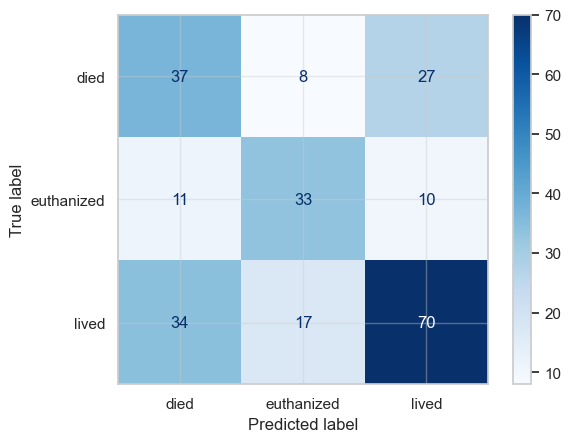

In [502]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["died","euthanized","lived"])

cmap = plt.get_cmap("Blues")
disp.plot(cmap=cmap)
plt.show()

In [503]:
report = classification_report(y_test, pred_y, target_names=["died","euthanized","lived"])
print(report)

              precision    recall  f1-score   support

        died       0.45      0.51      0.48        72
  euthanized       0.57      0.61      0.59        54
       lived       0.65      0.58      0.61       121

    accuracy                           0.57       247
   macro avg       0.56      0.57      0.56       247
weighted avg       0.58      0.57      0.57       247



In [522]:
#AUC_ROC
preds = model.predict_proba(X_test)
roc_auc_score(y_test, preds, multi_class='ovr')

0.7154715135791442

##### Plot a Decision Tree

In [505]:
model.n_features_in_

52

In [506]:
#fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 200)
#tree.plot_tree(model)

#target = list(df_train['outcome'].unique())
#feature_names = list(X.columns)

#dot_data = tree.export_graphviz(model,
                                #out_file=None, 
                      #feature_names=feature_names,  
                      #class_names=target,  
                      #filled=True, rounded=True,  
                      #special_characters=True)  
#graph = graphviz.Source(dot_data)  

#graph


##### Cross Validation

In [507]:
scores = cross_val_score(model, X_preprocessed_pipeline1, y, cv=10)

# Print the mean and standard deviation of the cross-validation scores
print('Cross-validation scores:', scores)
print('Mean score:', scores.mean())
print('Standard deviation:', scores.std())

Cross-validation scores: [0.58870968 0.51612903 0.56451613 0.57258065 0.54032258 0.62601626
 0.56910569 0.60162602 0.56910569 0.63414634]
Mean score: 0.5782258064516129
Standard deviation: 0.0342744147634967


### Hyperparameter Tuning

1. Max Depth

In [508]:
accScore =[]

for max_d in range(1,50):
  model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  model.fit(X_train, y_train)
  print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_train, y_train))
  print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
  print('')
  
  accScore.append(model.score(X_test,y_test))

The Training Accuracy for max_depth 1 is: 0.5637651821862348
The Validation Accuracy for max_depth 1 is: 0.5303643724696356

The Training Accuracy for max_depth 2 is: 0.6467611336032388
The Validation Accuracy for max_depth 2 is: 0.6194331983805668

The Training Accuracy for max_depth 3 is: 0.6609311740890689
The Validation Accuracy for max_depth 3 is: 0.6234817813765182

The Training Accuracy for max_depth 4 is: 0.6690283400809717
The Validation Accuracy for max_depth 4 is: 0.6153846153846154

The Training Accuracy for max_depth 5 is: 0.7135627530364372
The Validation Accuracy for max_depth 5 is: 0.6275303643724697

The Training Accuracy for max_depth 6 is: 0.7560728744939271
The Validation Accuracy for max_depth 6 is: 0.5991902834008097

The Training Accuracy for max_depth 7 is: 0.8107287449392713
The Validation Accuracy for max_depth 7 is: 0.6072874493927125

The Training Accuracy for max_depth 8 is: 0.8461538461538461
The Validation Accuracy for max_depth 8 is: 0.6153846153846154



In [509]:
max_value = max(accScore)
max_index = accScore.index(max_value)

print("Max Depth {} with Max Accuracy {}".format(max_index + 1, max_value))

Max Depth 5 with Max Accuracy 0.6275303643724697


#### 2. Max leaf nodes

In [510]:
accScore =[]

for max_d in range(2,50):
  model = DecisionTreeClassifier(max_leaf_nodes=max_d, random_state=42)
  model.fit(X_train, y_train)
  print('The Training Accuracy for max_depth {} is:'.format(max_d), model.score(X_train, y_train))
  print('The Validation Accuracy for max_depth {} is:'.format(max_d), model.score(X_test,y_test))
  print('')
  
  accScore.append(model.score(X_test,y_test))

The Training Accuracy for max_depth 2 is: 0.5637651821862348
The Validation Accuracy for max_depth 2 is: 0.5303643724696356

The Training Accuracy for max_depth 3 is: 0.6467611336032388
The Validation Accuracy for max_depth 3 is: 0.6194331983805668

The Training Accuracy for max_depth 4 is: 0.6467611336032388
The Validation Accuracy for max_depth 4 is: 0.6194331983805668

The Training Accuracy for max_depth 5 is: 0.6538461538461539
The Validation Accuracy for max_depth 5 is: 0.6194331983805668

The Training Accuracy for max_depth 6 is: 0.6538461538461539
The Validation Accuracy for max_depth 6 is: 0.6194331983805668

The Training Accuracy for max_depth 7 is: 0.6538461538461539
The Validation Accuracy for max_depth 7 is: 0.5910931174089069

The Training Accuracy for max_depth 8 is: 0.6720647773279352
The Validation Accuracy for max_depth 8 is: 0.6234817813765182

The Training Accuracy for max_depth 9 is: 0.6791497975708503
The Validation Accuracy for max_depth 9 is: 0.6275303643724697



In [511]:
max_value = max(accScore)
max_index = accScore.index(max_value)

print("Max Leaf Nodes {} with Max Accuracy {}".format(max_index + 1, max_value))

Max Leaf Nodes 8 with Max Accuracy 0.6275303643724697


##### Grid Search

In [512]:
clf = DecisionTreeClassifier(random_state=42)

params =  {
    'criterion': ["entropy", "gini"]
    ,'min_samples_leaf': range(1,5)
    ,'max_depth': range(1,9)
}

# Create gridsearch instance
#
grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                    param_grid=params,
                    cv=5,
                    n_jobs=1,
                    verbose=2)
#
# Fit the model
#
grid.fit(X_train, y_train)
#
# Assess the score
#
grid.best_score_, grid.best_params_


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=1; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=2; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=2; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=2; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=2; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=2; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_samples_leaf=3; total time=   0.0s
[CV] END .criterion=entropy, max_depth=1, min_s

(0.6407014305491463,
 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2})

##### Random Search CV

In [513]:
params =  {
    'criterion': ["entropy", "gini"]
    ,'min_samples_leaf': randint(1,5)
    ,'max_depth': randint(1,9)
}

rSearchCV = RandomizedSearchCV(
                    estimator = DecisionTreeClassifier(random_state=42),
                    param_distributions = params,
                    cv = 5,
                    n_jobs = 1,
                    verbose = 2
                    )

# Fit it to the data
rSearchCV.fit(X_test,y_test)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(rSearchCV.best_params_))
print("Best score is {}".format(rSearchCV.best_score_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=1; total time=   0.0s
[CV] END .criterion=entropy, max_depth=6, min_samples_leaf=4; total time=   0.0s
[CV] END .criterion=entropy, max_depth=6, min_samples_leaf=4; total time=   0.0s
[CV] END .criterion=entropy, max_depth=6, min_samples_leaf=4; total time=   0.0s
[CV] END .criterion=entropy, max_depth=6, min_samples_leaf=4; total time=   0.0s
[CV] END .criterion=entropy, max_depth=6, min_samples_leaf=4; total time=   0.0s
[CV] END ....criterion=gini, max_depth=6, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=6, min_sa

##### Best Model

In [520]:
bestmodel = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf = 3, random_state=42)
#Train the model
bestmodel.fit(X_train, y_train)
#Prediction
pred_y = bestmodel.predict(X_test)

# Accuracy
# Training test Accuracy
accuracy = accuracy_score(y_train,bestmodel.predict(X_train))
print("Train Accuracy:", accuracy)

# Test test Accuracy
accuracy = accuracy_score(y_test,pred_y)
print("Test Accuracy:", accuracy)

# Confusion Matrix
cmbest = confusion_matrix(y_test, pred_y)
print("\n****** Confusion Matrix *****")
print(cmbest)

Train Accuracy: 0.6518218623481782
Test Accuracy: 0.6396761133603239

****** Confusion Matrix *****
[[52  2 18]
 [17 30  7]
 [33 12 76]]


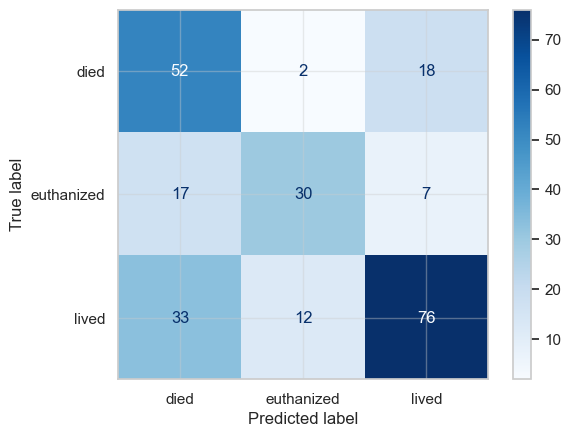

In [517]:
disp = ConfusionMatrixDisplay(confusion_matrix = cmbest, display_labels=["died","euthanized","lived"])

cmap = plt.get_cmap("Blues")
disp.plot(cmap=cmap)
plt.show()

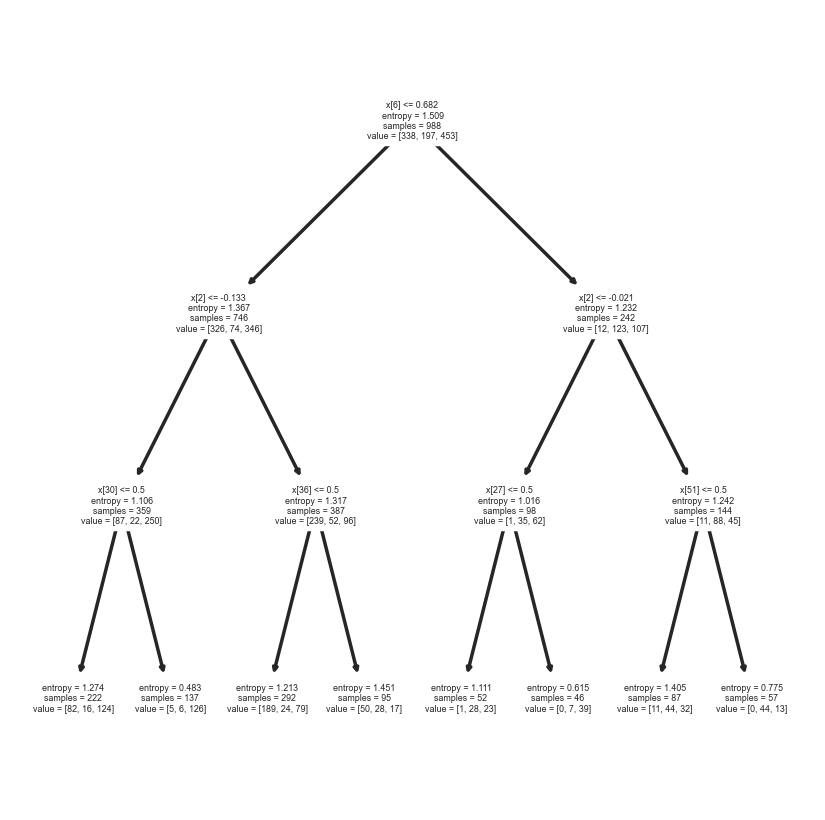

In [515]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi = 250)

tree.plot_tree(bestmodel);